# Data Loading

In [2]:
import os
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

In [3]:
def load_and_concat_csvs(folder_path):
    all_files = [
        os.path.join(folder_path, f)
        for f in os.listdir(folder_path)
        if f.endswith(".csv")
    ]
    
    df_list = []
    for file in all_files:
        df = pd.read_csv(file)
        df_list.append(df)
    
    combined_df = pd.concat(df_list, ignore_index=True)
    return combined_df

In [4]:
import os

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATASET_PATH = os.path.join(PROJECT_ROOT, "dataset")

print("Project root:", PROJECT_ROOT)
print("Dataset path:", DATASET_PATH)

Project root: e:\Ajinkya STUDY\UIDAI
Dataset path: e:\Ajinkya STUDY\UIDAI\dataset


In [5]:
BASE_PATH = "dataset"

enrolment_path = os.path.join(DATASET_PATH, "api_data_aadhar_enrolment")
demographic_path = os.path.join(DATASET_PATH, "api_data_aadhar_demographic")
biometric_path = os.path.join(DATASET_PATH, "api_data_aadhar_biometric")

enrolment_df = load_and_concat_csvs(enrolment_path)
demographic_df = load_and_concat_csvs(demographic_path)
biometric_df = load_and_concat_csvs(biometric_path)

In [6]:
print("Enrolment:", enrolment_df.shape)
print("Demographic:", demographic_df.shape)
print("Biometric:", biometric_df.shape)

enrolment_df.head()

Enrolment: (1006029, 7)
Demographic: (2071700, 6)
Biometric: (1861108, 6)


,date,state,district,pincode,age_0_5,age_5_17,age_18_greater
0,02-03-2025,Meghalaya,East Khasi Hills,793121,11,61,37
1,09-03-2025,Karnataka,Bengaluru Urban,560043,14,33,39
2,09-03-2025,Uttar Pradesh,Kanpur Nagar,208001,29,82,12
3,09-03-2025,Uttar Pradesh,Aligarh,202133,62,29,15
4,09-03-2025,Karnataka,Bengaluru Urban,560016,14,16,21


In [7]:
def standardise_columns(df):
    df.columns = (
        df.columns
        .str.strip()
        .str.lower()
    )
    return df

enrolment_df = standardise_columns(enrolment_df)
demographic_df = standardise_columns(demographic_df)
biometric_df = standardise_columns(biometric_df)

In [8]:
def clean_keys(df):
    df["state"] = df["state"].astype(str).str.strip()
    df["district"] = df["district"].astype(str).str.strip()
    df["pincode"] = df["pincode"].astype(str).str.strip()
    return df

enrolment_df = clean_keys(enrolment_df)
demographic_df = clean_keys(demographic_df)
biometric_df = clean_keys(biometric_df)

In [9]:
enrolment_df.duplicated(
    subset=["state", "district", "pincode"],
    keep=False
).sum()

np.int64(1004421)

In [10]:
enrolment_df = (
    enrolment_df
    .groupby(["state", "district", "pincode"], as_index=False)
    .agg({
        "age_0_5": "sum",
        "age_5_17": "sum",
        "age_18_greater": "sum"
    })
)

In [11]:
demographic_df = (
    demographic_df
    .groupby(["state", "district", "pincode"], as_index=False)
    .agg({
        "demo_age_5_17": "sum",
        "demo_age_17_": "sum"
    })
)

In [12]:
biometric_df = (
    biometric_df
    .groupby(["state", "district", "pincode"], as_index=False)
    .agg({
        "bio_age_5_17": "sum",
        "bio_age_17_": "sum"
    })
)

In [13]:
print(enrolment_df.shape)
print(demographic_df.shape)
print(biometric_df.shape)

(28982, 6)
(31495, 5)
(31295, 5)


In [14]:
master_df = enrolment_df.merge(
    demographic_df,
    on=["state", "district", "pincode"],
    how="left"
)

master_df = master_df.merge(
    biometric_df,
    on=["state", "district", "pincode"],
    how="left"
)

In [15]:
update_cols = [
    "demo_age_5_17",
    "demo_age_17_",
    "bio_age_5_17",
    "bio_age_17_"
]

master_df[update_cols] = master_df[update_cols].fillna(0)

In [16]:
master_df.shape

(28982, 10)

# Feature Engineering

### Goal of this phase

Convert raw counts into:

1. Normalised ratios
2. Lifecycle indicators
3. Update stress signals

These features are what anomaly detection will operate on.

In [17]:
master_df["total_enrolment"] = (
    master_df["age_0_5"]
    + master_df["age_5_17"]
    + master_df["age_18_greater"]
)

master_df["total_demo_updates"] = (
    master_df["demo_age_5_17"]
    + master_df["demo_age_17_"]
)

master_df["total_bio_updates"] = (
    master_df["bio_age_5_17"]
    + master_df["bio_age_17_"]
)

In [18]:
master_df[["total_enrolment", "total_demo_updates", "total_bio_updates"]].describe()

,total_enrolment,total_demo_updates,total_bio_updates
count,28982.000000,28982.000000,28982.000000
mean,187.554413,1700.086605,2406.577945
std,466.975480,3723.587799,3892.912770
min,1.000000,0.000000,0.000000
25%,18.000000,152.000000,255.000000
50%,59.000000,569.000000,1106.000000
75%,173.000000,1736.000000,2933.000000
max,15122.000000,115643.000000,78727.000000


In [ ]:
# Enrollment structure ratios (WHO is enrolling)
# These capture late vs early identity adoption.

master_df["child_enrol_ratio"] = (
    (master_df["age_0_5"] + master_df["age_5_17"])
    / master_df["total_enrolment"]
)

master_df["adult_enrol_ratio"] = (
    master_df["age_18_greater"]
    / master_df["total_enrolment"]
)

In [ ]:
# Update intensity ratios (HOW MUCH correction happens)

master_df["demo_update_ratio"] = (
    master_df["total_demo_updates"]
    / master_df["total_enrolment"]
)

master_df["bio_update_ratio"] = (
    master_df["total_bio_updates"]
    / master_df["total_enrolment"]
)

In [22]:
# Lifecycle efficiency indicators (KEY INSIGHT FEATURES)
master_df["update_efficiency"] = (
    (master_df["total_demo_updates"] + master_df["total_bio_updates"])
    / master_df["total_enrolment"]
)

# Adult update pressure - Measures how update-heavy adult lifecycle is.
master_df["adult_update_pressure"] = (
    (master_df["demo_age_17_"] + master_df["bio_age_17_"])
    / master_df["age_18_greater"].replace(0, np.nan)
)

# Child lifecycle gap - Expected: kids enrolled → kids updated over time.
master_df["child_update_gap"] = 1 - (
    (master_df["demo_age_5_17"] + master_df["bio_age_5_17"])
    / (master_df["age_0_5"] + master_df["age_5_17"]).replace(0, np.nan)
)

In [24]:
# Handle infinities & NaNs safely - This is not “cleaning”, this is correct modelling.

ratio_columns = [
    "child_enrol_ratio",
    "adult_enrol_ratio",
    "demo_update_ratio",
    "bio_update_ratio",
    "update_efficiency",
    "adult_update_pressure",
    "child_update_gap"
]

master_df[ratio_columns] = (
    master_df[ratio_columns]
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0)
)

In [26]:
master_df.to_csv("outputs/master_dataset_phase3_features.csv", index=False)

# Phase 3: EXPLORATORY DATA ANALYSIS (EDA)

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

### UNIVARIATE ANALYSIS
#### Purpose: Understand distributions and dominance

In [28]:
# Distribution of enrolments by age group
age_totals = {
    "0–5": master_df["age_0_5"].sum(),
    "5–17": master_df["age_5_17"].sum(),
    "18+": master_df["age_18_greater"].sum()
}

age_totals

{'0–5': np.int64(3546965), '5–17': np.int64(1720384), '18+': np.int64(168353)}

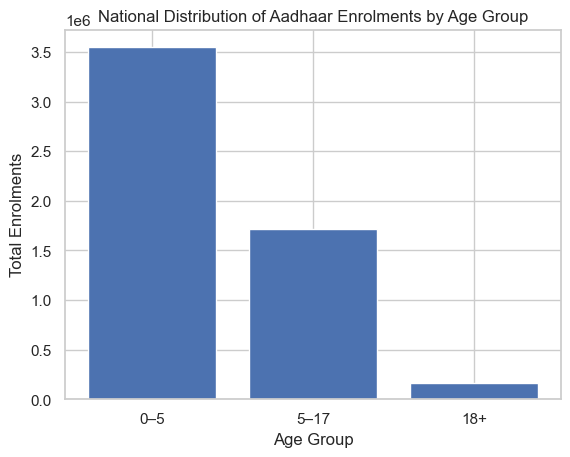

In [29]:
plt.figure()
plt.bar(age_totals.keys(), age_totals.values())
plt.title("National Distribution of Aadhaar Enrolments by Age Group")
plt.ylabel("Total Enrolments")
plt.xlabel("Age Group")
plt.show()

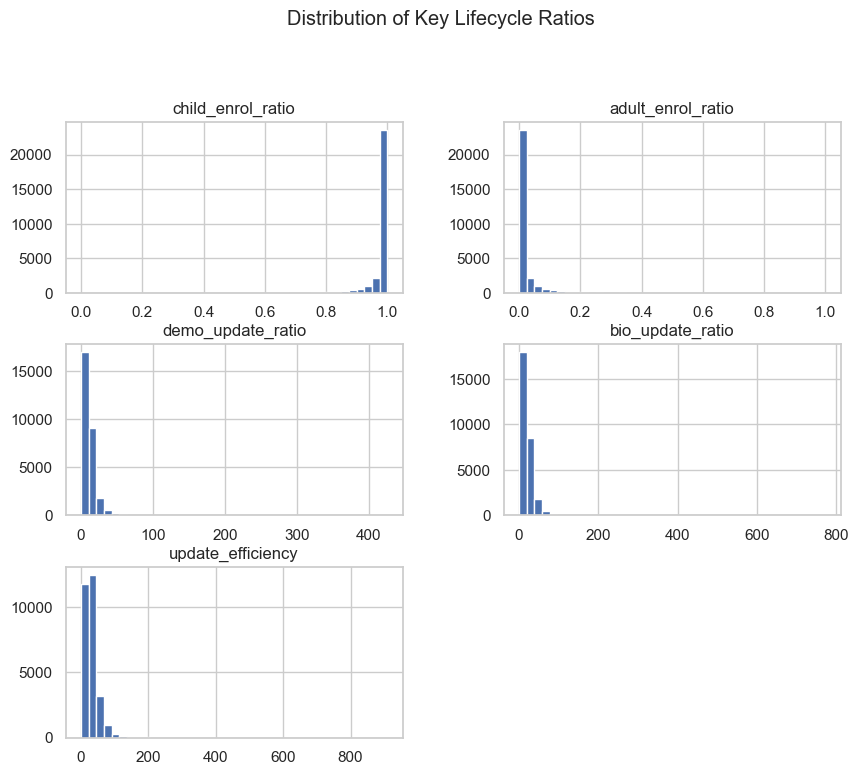

In [39]:
ratio_cols = [
    "child_enrol_ratio",
    "adult_enrol_ratio",
    "demo_update_ratio",
    "bio_update_ratio",
    "update_efficiency"
]

master_df[ratio_cols].hist(bins=40, figsize=(10, 8))
plt.suptitle("Distribution of Key Lifecycle Ratios", y=1.02)
plt.show()

## BIVARIATE ANALYSIS
### Purpose: Relationships between variables

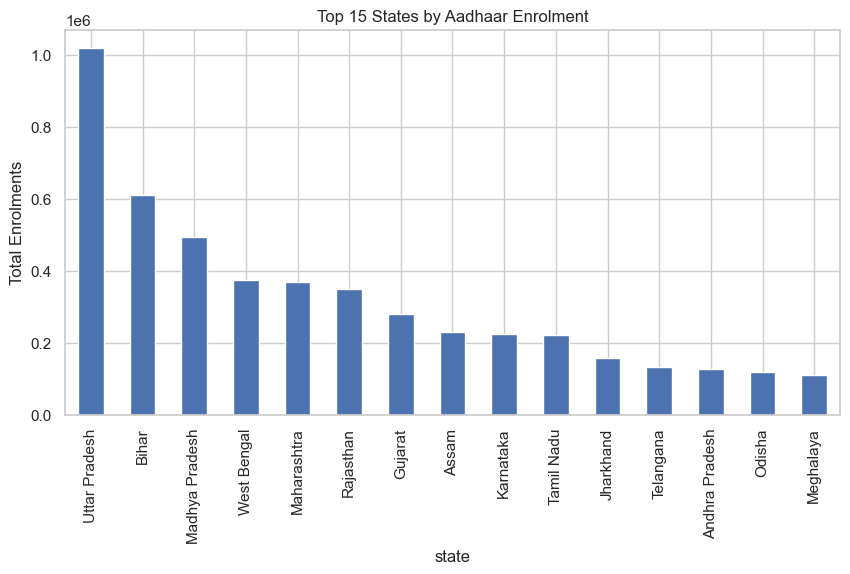

In [ ]:
# State vs enrolments

state_enrol = (
    master_df
    .groupby("state")["total_enrolment"]
    .sum()
    .sort_values(ascending=False)
    .head(15)
)

plt.figure(figsize=(10, 5))
state_enrol.plot(kind="bar")
plt.title("Top 15 States by Aadhaar Enrolment")
plt.ylabel("Total Enrolments")
plt.show()

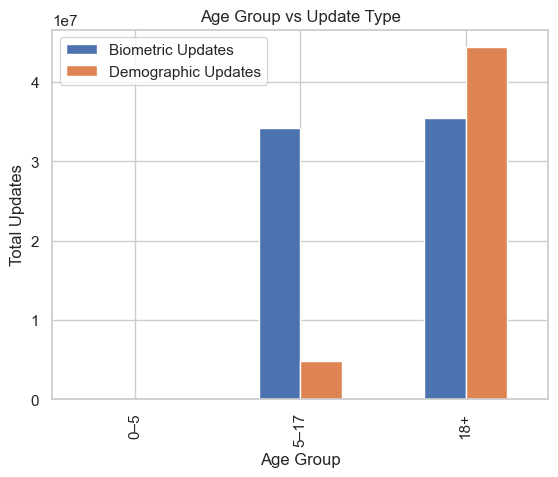

In [32]:
# Age group vs update type

age_update_df = pd.DataFrame({
    "Age Group": ["0–5", "5–17", "18+"],
    "Biometric Updates": [
        master_df["bio_age_5_17"].sum() * 0,  # none expected
        master_df["bio_age_5_17"].sum(),
        master_df["bio_age_17_"].sum()
    ],
    "Demographic Updates": [
        0,
        master_df["demo_age_5_17"].sum(),
        master_df["demo_age_17_"].sum()
    ]
})

age_update_df.set_index("Age Group").plot(kind="bar")
plt.title("Age Group vs Update Type")
plt.ylabel("Total Updates")
plt.show()

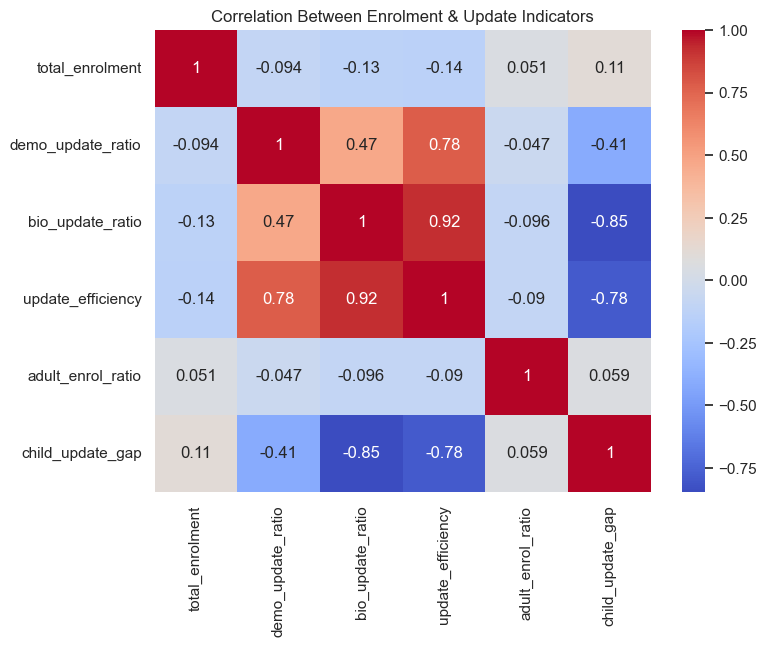

In [34]:
# Correlation heatmap (core relationship view)
corr_features = [
    "total_enrolment",
    "demo_update_ratio",
    "bio_update_ratio",
    "update_efficiency",
    "adult_enrol_ratio",
    "child_update_gap"
]

plt.figure(figsize=(8, 6))
sns.heatmap(
    master_df[corr_features].corr(),
    annot=True,
    cmap="coolwarm"
)
plt.title("Correlation Between Enrolment & Update Indicators")
plt.show()

## TRIVARIATE ANALYSIS
### Purpose: Multi-dimensional behavior

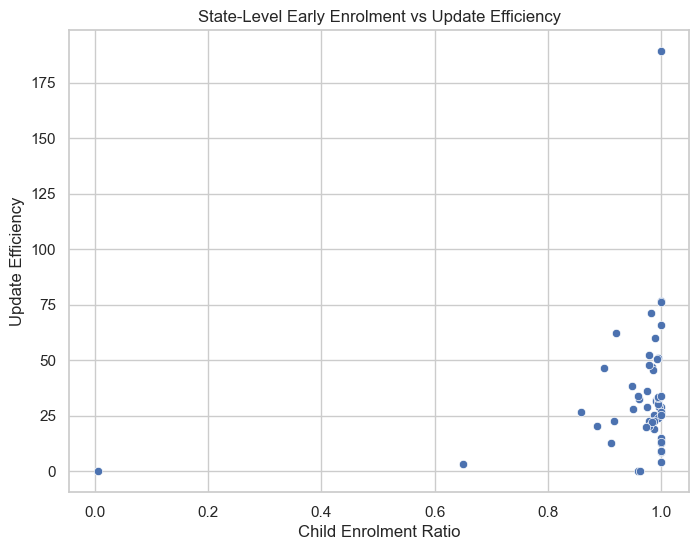

In [36]:
# State × Age × Update Efficiency

state_age_eff = (
    master_df
    .groupby("state")[["child_enrol_ratio", "update_efficiency"]]
    .mean()
    .reset_index()
)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=state_age_eff,
    x="child_enrol_ratio",
    y="update_efficiency"
)
plt.title("State-Level Early Enrolment vs Update Efficiency")
plt.xlabel("Child Enrolment Ratio")
plt.ylabel("Update Efficiency")
plt.show()

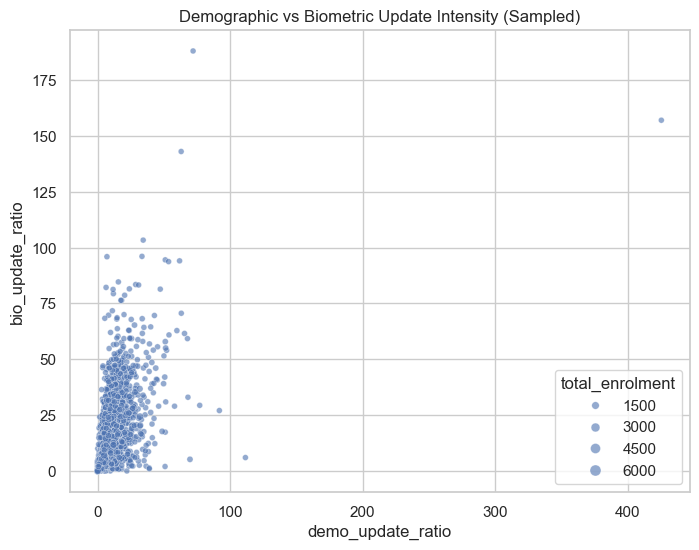

In [37]:
# District/Pincode × Update Type × Load
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=master_df.sample(2000, random_state=42),
    x="demo_update_ratio",
    y="bio_update_ratio",
    size="total_enrolment",
    alpha=0.6
)
plt.title("Demographic vs Biometric Update Intensity (Sampled)")
plt.show()

## GEOGRAPHIC & REGIONAL ANALYSIS


### Total Enrollment (State Wise)

In [40]:
state_enrolments = (
    master_df
    .groupby("state", as_index=False)["total_enrolment"]
    .sum()
    .sort_values("total_enrolment", ascending=False)
)

state_enrolments.head(10)


,state,total_enrolment
45,Uttar Pradesh,1018629
6,Bihar,609585
27,Madhya Pradesh,493970
51,West Bengal,375297
28,Maharashtra,369139
39,Rajasthan,348458
16,Gujarat,280549
5,Assam,230197
23,Karnataka,223235
41,Tamil Nadu,220789


### Enrolments Vs Updates Ratio

In [41]:
state_updates = (
    master_df
    .groupby("state", as_index=False)
    .agg({
        "total_enrolment": "sum",
        "total_demo_updates": "sum",
        "total_bio_updates": "sum"
    })
)

state_updates["update_to_enrol_ratio"] = (
    (state_updates["total_demo_updates"] + state_updates["total_bio_updates"])
    / state_updates["total_enrolment"]
)

state_updates.sort_values("update_to_enrol_ratio", ascending=False).head(10)


,state,total_enrolment,total_demo_updates,total_bio_updates,update_to_enrol_ratio
12,Daman & Diu,21,644.0,2185.0,134.714286
13,Daman and Diu,120,1552.0,6763.0,69.291667
33,ODISHA,1,44.0,22.0,66.000000
2,Andaman and Nicobar Islands,397,6115.0,18009.0,60.765743
7,Chandigarh,2723,83343.0,74461.0,57.952259
3,Andhra Pradesh,127681,2293359.0,3712238.0,47.035949
8,Chhattisgarh,103219,2004866.0,2647761.0,45.075296
10,Dadra and Nagar Haveli,744,6033.0,27235.0,44.715054
15,Goa,2333,35015.0,68298.0,44.283326
29,Manipur,13456,301362.0,282492.0,43.389863


## **Standardizing the rows and columns and removing the redunduant state names**

In [42]:
def normalize_state_text(s):
    if pd.isna(s):
        return s
    return (
        s.strip()
         .lower()
         .replace("&", "and")
         .replace("  ", " ")
    )

master_df["state_clean"] = master_df["state"].apply(normalize_state_text)


In [43]:
STATE_NAME_MAPPING = {
    # Andaman & Nicobar Islands
    "andaman and nicobar islands": "Andaman & Nicobar Islands",

    # Andhra Pradesh
    "andhra pradesh": "Andhra Pradesh",

    # Dadra and Nagar Haveli and Daman and Diu
    "dadra and nagar haveli": "Dadra and Nagar Haveli and Daman and Diu",
    "daman and diu": "Dadra and Nagar Haveli and Daman and Diu",
    "dadra and nagar haveli and daman and diu": "Dadra and Nagar Haveli and Daman and Diu",
    "the dadra and nagar haveli and daman and diu": "Dadra and Nagar Haveli and Daman and Diu",

    # Jammu and Kashmir
    "jammu and kashmir": "Jammu and Kashmir",

    # Odisha
    "odisha": "Odisha",
    "orissa": "Odisha",

    # Puducherry
    "puducherry": "Puducherry",
    "pondicherry": "Puducherry",

    # West Bengal
    "west bengal": "West Bengal",
    "westbengal": "West Bengal",
    "west bangal": "West Bengal"
}


In [44]:
def standardize_state_name(clean_name):
    return STATE_NAME_MAPPING.get(clean_name, clean_name.title())

master_df["state_standardized"] = master_df["state_clean"].apply(standardize_state_name)


In [45]:
print("Before standardization:")
print(master_df["state"].nunique())

print("After standardization:")
print(master_df["state_standardized"].nunique())


Before standardization:
55
After standardization:
37


In [46]:
master_df[
    master_df["state"].str.contains(
        "andaman|nicobar|odisha|orissa|bengal|kashmir|puducherry|pondicherry|daman|dadra",
        case=False,
        na=False
    )
][["state", "state_standardized"]].drop_duplicates()


,state,state_standardized
1,Andaman & Nicobar Islands,Andaman & Nicobar Islands
15,Andaman and Nicobar Islands,Andaman & Nicobar Islands
5500,Dadra & Nagar Haveli,Dadra and Nagar Haveli and Daman and Diu
5501,Dadra and Nagar Haveli,Dadra and Nagar Haveli and Daman and Diu
5505,Dadra and Nagar Haveli and Daman and Diu,Dadra and Nagar Haveli and Daman and Diu
5514,Daman & Diu,Dadra and Nagar Haveli and Daman and Diu
5519,Daman and Diu,Dadra and Nagar Haveli and Daman and Diu
7976,Jammu & Kashmir,Jammu and Kashmir
8034,Jammu And Kashmir,Jammu and Kashmir
8036,Jammu and Kashmir,Jammu and Kashmir


In [47]:
master_df["state"] = master_df["state_standardized"]
master_df = master_df.drop(columns=["state_clean", "state_standardized"])


### Geographical and statistical analysis

In [48]:
state_enrolments = (
    master_df
    .groupby("state", as_index=False)["total_enrolment"]
    .sum()
    .sort_values("total_enrolment", ascending=False)
)

state_enrolments.head(10)


,state,total_enrolment
34,Uttar Pradesh,1018629
5,Bihar,609585
20,Madhya Pradesh,493970
36,West Bengal,375340
21,Maharashtra,369139
29,Rajasthan,348458
11,Gujarat,280549
4,Assam,230197
16,Karnataka,223235
31,Tamil Nadu,220789


In [53]:
child_enrolments = (
    master_df
    .groupby("state", as_index=False)["child_enrol_ratio"]
    .mean()
    .sort_values("child_enrol_ratio", ascending=False)
)

child_enrolments.head(10)

,state,child_enrol_ratio
1,Andaman & Nicobar Islands,1.000000
26,Odisha,0.996474
19,Lakshadweep,0.996169
32,Telangana,0.995185
35,Uttarakhand,0.995015
31,Tamil Nadu,0.994697
7,Chhattisgarh,0.994433
15,Jharkhand,0.993687
13,Himachal Pradesh,0.991489
12,Haryana,0.991431


In [49]:
state_updates = (
    master_df
    .groupby("state", as_index=False)
    .agg({
        "total_enrolment": "sum",
        "total_demo_updates": "sum",
        "total_bio_updates": "sum"
    })
)

state_updates["update_to_enrol_ratio"] = (
    (state_updates["total_demo_updates"] + state_updates["total_bio_updates"])
    / state_updates["total_enrolment"]
)

state_updates.sort_values("update_to_enrol_ratio", ascending=False).head(10)


,state,total_enrolment,total_demo_updates,total_bio_updates,update_to_enrol_ratio
6,Chandigarh,2723,83343.0,74461.0,57.952259
1,Andaman & Nicobar Islands,511,7144.0,20348.0,53.800391
2,Andhra Pradesh,127686,2293436.0,3712279.0,47.035031
7,Chhattisgarh,103219,2004866.0,2647761.0,45.075296
10,Goa,2333,35015.0,68298.0,44.283326
22,Manipur,13456,301362.0,282492.0,43.389863
21,Maharashtra,369139,5050577.0,9224091.0,38.670170
33,Tripura,11285,137947.0,292104.0,38.108197
28,Punjab,76746,881387.0,1739041.0,34.144164
27,Puducherry,3017,32735.0,69848.0,34.001657


In [51]:
state_lifecycle = (
    master_df
    .groupby("state", as_index=False)
    .agg({
        "child_enrol_ratio": "mean",
        "update_efficiency": "mean"
    })
)

high_adoption_low_maintenance = state_lifecycle[
    (state_lifecycle["child_enrol_ratio"] > 0.7) &
    (state_lifecycle["update_efficiency"] < 0.25)
]

high_adoption_low_maintenance



,state,child_enrol_ratio,update_efficiency


In [54]:
state_lifecycle.sort_values("update_efficiency").head(10)


,state,child_enrol_ratio,update_efficiency
0,100000,0.004587,0.009174
23,Meghalaya,0.650513,3.165880
4,Assam,0.912134,12.516628
5,Bihar,0.986762,19.129427
36,West Bengal,0.973269,19.938890
20,Madhya Pradesh,0.977712,20.173058
25,Nagaland,0.886612,20.276497
14,Jammu and Kashmir,0.989133,21.563819
34,Uttar Pradesh,0.983031,22.314410
16,Karnataka,0.978687,22.472825


### Identifying underserved regions

In [55]:
low_enrol_thresh = master_df["total_enrolment"].quantile(0.25)
low_update_thresh = master_df["update_efficiency"].quantile(0.25)

underserved_regions = master_df[
    (master_df["total_enrolment"] < low_enrol_thresh) &
    (master_df["update_efficiency"] < low_update_thresh)
]

underserved_regions[
    ["state", "district", "pincode", "total_enrolment", "update_efficiency"]
].head(20)


,state,district,pincode,total_enrolment,update_efficiency
5,Andaman & Nicobar Islands,Andamans,744107,7,10.285714
6,Andaman & Nicobar Islands,Andamans,744206,5,12.000000
7,Andaman & Nicobar Islands,Andamans,744207,2,2.000000
8,Andaman & Nicobar Islands,Nicobars,744301,1,6.000000
9,Andaman & Nicobar Islands,South Andaman,744102,1,11.000000
10,Andaman & Nicobar Islands,South Andaman,744103,12,16.166667
12,Andaman & Nicobar Islands,South Andaman,744107,6,15.166667
14,Andaman & Nicobar Islands,South Andaman,744207,1,2.000000
21,Andaman & Nicobar Islands,North And Middle Andaman,744203,5,5.000000
95,Andhra Pradesh,Alluri Sitharama Raju,531114,1,0.000000


## Regions where Aadhar exists but system infrastructure lacks

In [ ]:
infra_deserts = master_df[
    (master_df["total_enrolment"] > master_df["total_enrolment"].median()) &
    (master_df["update_efficiency"] < 0.1)
]

infra_deserts[
    ["state", "district", "pincode", "total_enrolment", "update_efficiency"]
].head(20)


# 230 rows match the criteria

,state,district,pincode,total_enrolment,update_efficiency
0,100000,100000,100000,218,0.009174
2237,Andhra Pradesh,Spsr Nellore,524002,65,0.000000
2238,Andhra Pradesh,Spsr Nellore,524004,296,0.000000
2239,Andhra Pradesh,Spsr Nellore,524201,332,0.000000
2240,Andhra Pradesh,Spsr Nellore,524223,81,0.000000
2241,Andhra Pradesh,Spsr Nellore,524304,62,0.000000
2242,Andhra Pradesh,Spsr Nellore,524305,183,0.000000
2243,Andhra Pradesh,Spsr Nellore,524308,85,0.000000
2244,Andhra Pradesh,Spsr Nellore,524309,80,0.000000
2246,Andhra Pradesh,Spsr Nellore,524315,217,0.000000


## High Activity Regions

In [61]:
high_activity = master_df[
    master_df["update_efficiency"] >
    master_df["update_efficiency"].quantile(0.95)
]

high_activity[
    ["state", "district", "pincode", "update_efficiency"]
].head(20)

# 1448 rows match the criteria


,state,district,pincode,update_efficiency
1,Andaman & Nicobar Islands,Andamans,744101,180.777778
16,Andaman & Nicobar Islands,Nicobar,744302,110.666667
17,Andaman & Nicobar Islands,Nicobar,744303,172.000000
18,Andaman & Nicobar Islands,Nicobar,744304,156.000000
19,Andaman & Nicobar Islands,North And Middle Andaman,744201,79.416667
20,Andaman & Nicobar Islands,North And Middle Andaman,744202,76.519231
26,Andaman & Nicobar Islands,South Andaman,744101,82.333333
28,Andaman & Nicobar Islands,South Andaman,744103,111.958333
30,Andaman & Nicobar Islands,South Andaman,744105,74.295455
32,Andaman & Nicobar Islands,South Andaman,744107,220.750000


## Lower Activity Regions

In [64]:
low_activity = master_df[
    master_df["update_efficiency"] <
    master_df["update_efficiency"].quantile(0.05)
]

low_activity[
    ["state", "district", "pincode", "update_efficiency"]
].head(20)

# 1450 rows match the criteria


,state,district,pincode,update_efficiency
0,100000,100000,100000,0.009174
7,Andaman & Nicobar Islands,Andamans,744207,2.000000
14,Andaman & Nicobar Islands,South Andaman,744207,2.000000
95,Andhra Pradesh,Alluri Sitharama Raju,531114,0.000000
493,Andhra Pradesh,Bapatla,522315,4.000000
625,Andhra Pradesh,Chittoor,635121,2.500000
683,Andhra Pradesh,Cuddapah,516361,1.000000
1051,Andhra Pradesh,Guntur,522510,3.000000
1138,Andhra Pradesh,K.V.Rangareddy,500008,3.857143
1140,Andhra Pradesh,K.V.Rangareddy,500019,0.500000


In [68]:
unique_high_activity_states = high_activity["state"].unique()
unique_low_activity_states = low_activity["state"].unique()

In [69]:
print("Unique states in high activity regions:", unique_high_activity_states)
print("Unique states in low activity regions:", unique_low_activity_states)

Unique states in high activity regions: ['Andaman & Nicobar Islands' 'Andhra Pradesh' 'Arunachal Pradesh' 'Assam'
 'Bihar' 'Chandigarh' 'Chhattisgarh'
 'Dadra and Nagar Haveli and Daman and Diu' 'Delhi' 'Goa' 'Gujarat'
 'Haryana' 'Himachal Pradesh' 'Jammu and Kashmir' 'Jharkhand' 'Karnataka'
 'Kerala' 'Ladakh' 'Madhya Pradesh' 'Maharashtra' 'Manipur' 'Mizoram'
 'Odisha' 'Puducherry' 'Punjab' 'Rajasthan' 'Tamil Nadu' 'Telangana'
 'Tripura' 'Uttar Pradesh' 'Uttarakhand' 'West Bengal']
Unique states in low activity regions: ['100000' 'Andaman & Nicobar Islands' 'Andhra Pradesh' 'Arunachal Pradesh'
 'Assam' 'Bihar' 'Chandigarh' 'Chhattisgarh' 'Delhi' 'Goa' 'Gujarat'
 'Haryana' 'Jammu and Kashmir' 'Jharkhand' 'Karnataka' 'Kerala'
 'Madhya Pradesh' 'Maharashtra' 'Manipur' 'Meghalaya' 'Mizoram' 'Nagaland'
 'Odisha' 'Puducherry' 'Punjab' 'Rajasthan' 'Sikkim' 'Tamil Nadu'
 'Telangana' 'Dadra and Nagar Haveli and Daman and Diu' 'Uttar Pradesh'
 'Uttarakhand' 'West Bengal']


### ***It is important to note that The coexistence of high-activity and low-activity pincodes within individual states highlights localized infrastructure stress and access gaps, underscoring the need for targeted, district-level interventions rather than uniform state-wide policies.***